In [1]:
import pandas as pd
import requests
import pandas as pd
import re
import emoji
import unicodedata
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
from collections import Counter
from wordcloud import WordCloud
import joblib

In [2]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_colwidth")

dfFilm = pd.read_csv("film_reviews.csv") #dữ liệu gốc
print(dfFilm["comment"].size)
dfFilm = dfFilm.dropna(subset=["comment"]) #bỏ comment trống
print(dfFilm["comment"].size,'\n\n')
dfFilm["ratings"] = dfFilm["ratings"].str.extract(r"^(\d+\/\d+)")
dfFilm

14190
13651 




,author,comment,ratings,title,url
0,Võ Kim Uyên,"Quang Tuấn quá đỉnh, kỹ xảo tuyệt vời, khúc cu...",10/10,Truy Tìm Long Diên Hương,https://www.momo.vn/cinema/truy-tim-long-dien-...
1,Đào Thị Thanh Bình,"Phim hay .............,,,,,,,,,,,,,,,,,,,,,,,,...",9/10,Truy Tìm Long Diên Hương,https://www.momo.vn/cinema/truy-tim-long-dien-...
2,Phan Phan Tống Ngọc,"Thật sự không còn từ nào diễn tả ngoài 1 chữ ""...",10/10,Truy Tìm Long Diên Hương,https://www.momo.vn/cinema/truy-tim-long-dien-...
3,Trần Thị Ngọc Yến,Cười mà sái quai hàm luôn\nNhưng mà cũng kịch ...,10/10,Truy Tìm Long Diên Hương,https://www.momo.vn/cinema/truy-tim-long-dien-...
4,Nguyễn Ngọc Thùy Dương,"Phim dễ thương xĩu luôn, rất hay và giải trí nha",10/10,Truy Tìm Long Diên Hương,https://www.momo.vn/cinema/truy-tim-long-dien-...
...,...,...,...,...,...
14185,Vũ Thanh Huế,thấy hù nhiều chứ cũng bình thường,7/10,Ác Linh Trong Xác Mẹ,https://www.momo.vn/cinema/menjelang-ajal-2387...
14186,Nguyễn Quang Sáng,Phim dỡ tệ,1/10,Ác Linh Trong Xác Mẹ,https://www.momo.vn/cinema/menjelang-ajal-2387...
14187,Nguyễn Chính Hồng Phong,Như dở hơi =))) thề,3/10,Ác Linh Trong Xác Mẹ,https://www.momo.vn/cinema/menjelang-ajal-2387...
14188,Hoàng Thị Thùy Dương,Nội dung phim bị rắc rối mình xem hết phim như...,5/10,Ác Linh Trong Xác Mẹ,https://www.momo.vn/cinema/menjelang-ajal-2387...


In [3]:
def sample_rating(df, rating_text, n):
    """Hàm sample 1 rating cụ thể xuống n mẫu"""
    df_group = df[df["ratings"].str.contains(rating_text, na=False)]
    df_sampled = df_group.sample(n=n, random_state=42)
    df_other = df[~df["ratings"].str.contains(rating_text, na=False)]
    return df_other, df_sampled


In [4]:
for i in range(1, 11):
    pattern = f"{i}/10"
    count = dfFilm[dfFilm["ratings"].str.contains(pattern, na=False)].shape[0]
    print(f"{pattern}: {count} comments")

1/10: 1123 comments
2/10: 229 comments
3/10: 210 comments
4/10: 230 comments
5/10: 391 comments
6/10: 438 comments
7/10: 588 comments
8/10: 1261 comments
9/10: 1389 comments
10/10: 7792 comments


<Axes: xlabel='ratings', ylabel='count'>

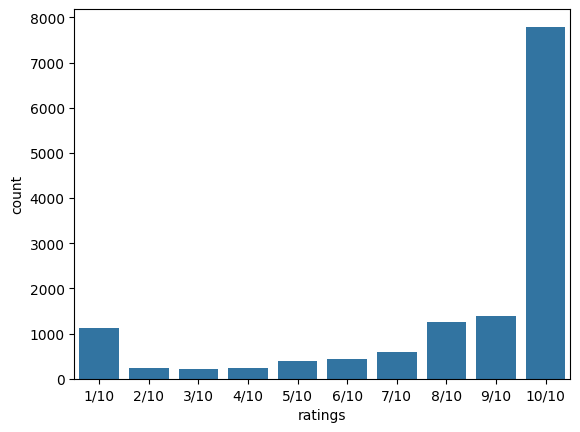

In [5]:
import seaborn as sns
order = [f"{i}/10" for i in range(1, 11)]
sns.countplot(data=dfFilm,x=dfFilm["ratings"], order=order)

<Axes: xlabel='ratings', ylabel='count'>

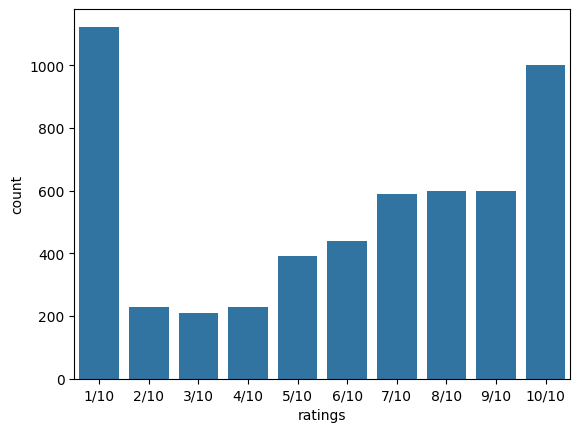

In [6]:
df = dfFilm 

# Giảm 10/10 → 1200
df, df_10 = sample_rating(df, "10/10", 1000)

# Giảm 9/10 → 800
df, df_9 = sample_rating(df, "9/10", 600)

# Giảm 8/10 → 800
df, df_8 = sample_rating(df, "8/10", 600)

# Ghép lại toàn bộ
dfFilm = pd.concat([df, df_10, df_9, df_8], ignore_index=True)

order = [f"{i}/10" for i in range(1, 11)]
sns.countplot(data=df,x=dfFilm["ratings"], order=order)

In [7]:
# =====================================================
# Slang + stopword + block
# =====================================================

SLANG_MAP = {
    "ko": "không",
    "k": "không",
    "kg": "không",
    "hok": "không",
    "hk": "không",
    "khum": "không",
    "kh": "không",
    "hem": "không",
    "khôg": "không",
    "khog": "không",


    "10đ": "10 điểm",
    "đỉm": "điểm",
    "dvien": "diễn viên",
    "dv": "diễn viên",
    "rv": "review",
    "ng": "người",
    "chớt": "chết",
    "cừ": "cười",
    "dỡ": "dở",
    "rcm": "recommend",
    "nv": "nhân vật",
    "nvat": "nhân vật",
    "nd": "nội dung",
    "thiệc": "thiệt",
    "nhãm": "nhảm",
    "đv": "đối với",
    "lun": "luôn",
    "mún": "muốn",

    
    "cũm": "cũng",
    "cx": "cũng",
    "vs": "với",
    "nma": "nhưng mà",
    "bth": "bình thường",
    "zui": "vui",
    "bngu": "buồn ngủ",
    "tr": "trời",
    "lquan": "liên quan",
    "tg": "thời gian",    

    "dc": "được",
    "đc": "được",
    "dk": "được",


    "oke": "ok",
    "okie": "ok",

    "vl": "vãi",
    "vcl": "vãi",
    "v": "vậy",


    "t": "tôi",       
    "mk": "mình",
    "mn": "mọi người",
    "mng": "mọi người",
    "củng": "cũng",
    "cũg": "cũng",

}

STOPWORDS = {
    "và","với","thì","là","mà","nhé","nhỉ","chứ","đấy","này","ấy","đó","thế","vậy",
    "ơ","ờ","ừ","à","đã","đang","rằng","trong","khi","nào","để","tại","từng",
    "ra","vào","ơi"
}

BLOCKED_WORDS = {"pass"}

# =====================================================
# 1. CLEAN + NORMALIZE 
# =====================================================
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = unicodedata.normalize("NFC", text).lower()

    # remove url
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # slang
    for k, v in SLANG_MAP.items():
        text = re.sub(rf"\b{k}\b", v, text)

    # newline + kéo dài
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # tách emoji
    text = "".join(
        f" {ch} " if ch in emoji.EMOJI_DATA else ch
        for ch in text
    )

    # bỏ dấu câu
    text = re.sub(r"[.,!?…;:()\"']", " ", text)

    # normalize space
    text = re.sub(r"\s+", " ", text).strip()

    words = [w for w in text.split() if w not in STOPWORDS]

    return " ".join(words)

# =====================================================
# 2. LABEL + FEATURE
# =====================================================
def has_emoji_fn(text):
    if not isinstance(text, str):
        return 0
    return 1 if any(char in emoji.EMOJI_DATA for char in text) else 0

#----------------------------
def rating_to_label(rating):
    # rating dạng "7/10 · Đáng xem"
    score = int(rating.split("/")[0])  # lấy số trước dấu "/"
    
    if score in [1, 2, 3, 4]:
        return "negative"
    elif score in [5, 6, 7]:
        return "mixed/neutral"
    elif score in [8, 9, 10]:
        return "positive"
    else:
        return ""


In [8]:
# =====================================================
# 3. APPLY
# =====================================================
dfFilm["cleaned_text"] = dfFilm["comment"].apply(clean_text) #input: cột comment gốc, output: tạo cột cleaned_text

dfFilm = dfFilm[~dfFilm["cleaned_text"].str.contains("|".join(BLOCKED_WORDS))] #filter

# cột length
dfFilm["length"] = dfFilm["cleaned_text"].apply(lambda x: len(x.split()))
# cột has_emoji
dfFilm["has_emoji"] = dfFilm["comment"].apply(has_emoji_fn)
# cột label
dfFilm["label"] = dfFilm["ratings"].apply(rating_to_label)

# Save file mới
dfFilm["ratings"] = " " + dfFilm["ratings"].astype(str)
dfFilm.to_csv("film_cleaned.csv", index=False, encoding="utf-8-sig")